<a href="https://colab.research.google.com/github/voquyen0502/Protein-Ligand-Binding-Affinity/blob/main/KISS_GP_Protein_Ligand_Affinity_with_train_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Library

In [1]:
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>

In [2]:
# !pip install -U sentence-transformers
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 7.5 MB/s eta 0:00:00


#Import Library

In [3]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy.stats import spearmanr
import os
import re
import glob
import gc
import time

import math
import tqdm
from tqdm.notebook import tqdm as tqdm1
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

#Support Functions

In [4]:
def format_time(time):
  if len(time) < 2:
    return "0"+time
  return time
def to_time(t):
  s = format_time(str(t%60))
  m = format_time(str(t//60%60))
  h = format_time(str(t//3600))
  return h+":"+m+":"+s
def progress_bar(desc, t, i, n):
  eta = int(t*(n-i)/i) if i else 0
  pg = round(i*40/n)
  print('\r'+desc, '[ elapsed:', to_time(t),']', "|"+"="*pg+" "*(40-pg)+"|", str(round(i*100/n))+"%", '( ETA:', to_time(eta), ')', end="", flush=True)

In [5]:
def split(X, y, train_size, random_state):
  if train_size == 1.0:
    return train_test_split(X, y, train_size = len(X)-1, random_state=random_state)
  return train_test_split(X, y, train_size = train_size, random_state=random_state)


In [6]:
def evaluate(X, y, GPs):
  yhat = GPs(X).mean
  mse = mean_squared_error(y, yhat)
  rmse = mean_squared_error(y, yhat, squared = False)
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  spearman = spearmanr(y, yhat).correlation
  r2 = r2_score(y, yhat)
  return [mse, rmse, mae, mape, spearman, r2]

In [7]:
def train(X, y, epoch, GPs):
    iterator = tqdm1(range(epoch))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = GPs(X)
        # Calc loss and backprop derivatives
        loss = -mll(output, y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

In [8]:
def plt_train_test(x_values, err_train, err_test, x_label):
    fig, ax = plt.subplots(1, 6, figsize=(24, 4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    errors = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Spearman', 'R-squared']
    for i in range(6):
      ax[i].set_title(errors[i],fontsize = 12)
      ax[i].plot(x_values, [err_train[j][i] for j in range(len(x_values))], marker='o',label="train error", lw=2,  color = "blue")
      ax[i].plot(x_values, [err_test[j][i] for j in range(len(x_values))],    marker='o',label="test error",  lw=2, color = "green")
      ax[i].set_ylim(*ax[i].get_ylim())
      ax[i].set_xlabel(x_label)
      ax[i].set_ylabel("Error")
      ax[i].legend()
    fig.suptitle("Evaluate vs train size",fontsize = 12)
    plt.tight_layout()
    plt.show()

#Download Dataset

In [9]:
!gdown 18S8MYwxljaYPYYn5QqlvFDN1myBwQunA
df = pd.read_csv('feature.csv', index_col=0)

Downloading...
From: https://drive.google.com/uc?id=18S8MYwxljaYPYYn5QqlvFDN1myBwQunA
To: /content/feature.csv
100% 191M/191M [00:03<00:00, 50.3MB/s]


#Preprocessing

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1783,1784,1785,1786,1787,1788,1789,1790,1791,label
0,-0.211700,-0.205539,0.337126,-0.056080,0.119349,0.243540,-0.126496,0.264932,0.315239,-0.118922,...,-0.315158,-0.742068,0.517479,0.007870,-0.881757,0.433979,0.381069,-0.682113,0.717024,5.486783
1,-0.189175,-0.087662,0.233187,0.127165,0.137902,0.147014,-0.202607,0.169478,0.213779,-0.248068,...,-0.063049,-0.192722,-0.550342,0.057612,0.100607,0.089984,0.683167,0.459728,-0.452435,3.602060
2,0.082610,-0.320745,-0.124809,0.018967,0.165369,-0.143138,-0.391910,-0.077087,-0.069667,-0.388979,...,-0.404161,-0.843317,0.149106,0.767675,-0.909352,0.172291,0.703071,0.504158,-0.543714,7.920819
3,-0.084273,-0.101664,0.112304,0.102400,0.110600,0.081240,-0.236201,0.104819,0.113949,-0.268406,...,-0.475812,-0.822818,-0.425321,0.856794,-0.981262,0.020445,0.348573,-0.298878,-0.356281,9.096910
4,-0.238835,0.028666,0.330590,0.121576,0.108433,0.286374,-0.096377,0.277651,0.297153,-0.141224,...,-0.173999,-0.601604,0.617227,-0.180792,-0.954172,0.354371,0.056249,-0.505679,0.303446,3.332547


In [11]:
X = df.drop('label', axis = 1).values.astype(np.float32)
y = df.label.values.astype(np.float32)
X = torch.tensor(X)
y = torch.tensor(y)

In [12]:
X_, X_test, y_, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [13]:
data_dim = X_.size(-1)
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 1000))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(1000, 1000))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(1000, 2))

feature_extractor = LargeFeatureExtractor()

In [14]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, X_train, y_train, likelihood):
            super(GPRegressionModel, self).__init__(X_train, y_train, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [20]:
epoch = 300
n_times = 3
ratio = (np.array(range(1,11))/10).tolist()
test_err_ratio = np.zeros((n_times,10,6)).tolist()
GPs = [[None for _ in range(10)]]*n_times
likelihood = [[None for _ in range(10)]]*n_times
for i in range(n_times):
  for j in range(10):
      X_train, _, y_train, _ = split(X_, y_, train_size = ratio[j], random_state=8)
      likelihood[i][j] = gpytorch.likelihoods.GaussianLikelihood()
      GPs[i][j] = GPRegressionModel(X_train, y_train, likelihood[i][j])

      if torch.cuda.is_available():
          GPs[i][j] = GPs[i][j].cuda()
          likelihood[i][j] = likelihood[i][j].cuda()

      # Find optimal model hyperparameters
      GPs[i][j].train()
      likelihood[i][j].train()

      # Use the adam optimizer
      optimizer = torch.optim.Adam([
          {'params': GPs[i][j].feature_extractor.parameters()},
          {'params': GPs[i][j].covar_module.parameters()},
          {'params': GPs[i][j].mean_module.parameters()},
          {'params': GPs[i][j].likelihood.parameters()},
      ], lr=0.01)

      # "Loss" for GPs - the marginal log likelihood
      mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood[i][j], GPs[i][j])
      %time train(X_train, y_train, epoch, GPs[i][j])
      GPs[i][j].eval()
      likelihood[i][j].eval()
      with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
          test_err_ratio[i][j] = evaluate(X_test, y_test, GPs[i][j])

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 14min 13s, sys: 3min 45s, total: 17min 58s
Wall time: 9min 4s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 4min 32s, sys: 637 ms, total: 4min 33s
Wall time: 2min 16s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 5min 27s, sys: 698 ms, total: 5min 27s
Wall time: 2min 43s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 6min 18s, sys: 789 ms, total: 6min 19s
Wall time: 3min 9s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 15min 8s, sys: 53.3 s, total: 16min 1s
Wall time: 8min 1s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 17min 41s, sys: 2min 3s, total: 19min 45s
Wall time: 9min 53s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 20min 9s, sys: 2min 22s, total: 22min 31s
Wall time: 11min 16s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 22min 31s, sys: 2min 48s, total: 25min 19s
Wall time: 12min 41s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 25min 3s, sys: 3min 14s, total: 28min 17s
Wall time: 14min 10s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 27min 15s, sys: 3min 46s, total: 31min 1s
Wall time: 15min 31s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 14min 38s, sys: 5min 31s, total: 20min 9s
Wall time: 10min 14s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 4min 32s, sys: 646 ms, total: 4min 33s
Wall time: 2min 16s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 5min 24s, sys: 738 ms, total: 5min 25s
Wall time: 2min 42s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 6min 15s, sys: 764 ms, total: 6min 16s
Wall time: 3min 8s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 15min 14s, sys: 1min 41s, total: 16min 56s
Wall time: 8min 28s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 17min 33s, sys: 2min 14s, total: 19min 48s
Wall time: 9min 54s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 20min 4s, sys: 2min 33s, total: 22min 37s
Wall time: 11min 20s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 22min 25s, sys: 2min 56s, total: 25min 22s
Wall time: 12min 42s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 24min 40s, sys: 3min 18s, total: 27min 59s
Wall time: 14min 1s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 23min 45s, sys: 2min 45s, total: 26min 30s
Wall time: 13min 15s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 14min 26s, sys: 5min 16s, total: 19min 42s
Wall time: 9min 59s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 4min 30s, sys: 667 ms, total: 4min 31s
Wall time: 2min 15s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 5min 24s, sys: 706 ms, total: 5min 24s
Wall time: 2min 42s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 6min 16s, sys: 731 ms, total: 6min 16s
Wall time: 3min 8s


  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 12min 53s, sys: 45 s, total: 13min 38s
Wall time: 6min 49s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 14min 34s, sys: 12.2 s, total: 14min 46s
Wall time: 7min 23s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 17min 39s, sys: 1min 35s, total: 19min 15s
Wall time: 9min 38s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 20min 18s, sys: 2min 17s, total: 22min 35s
Wall time: 11min 18s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 22min 29s, sys: 2min 32s, total: 25min 2s
Wall time: 12min 33s


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


CPU times: user 24min 52s, sys: 3min 4s, total: 27min 56s
Wall time: 13min 59s


#Evaluating

In [21]:
test_err = np.array(test_err_ratio)
test_err_mean = np.mean(test_err, axis = 0)
test_err_std = np.std(test_err, axis = 0)

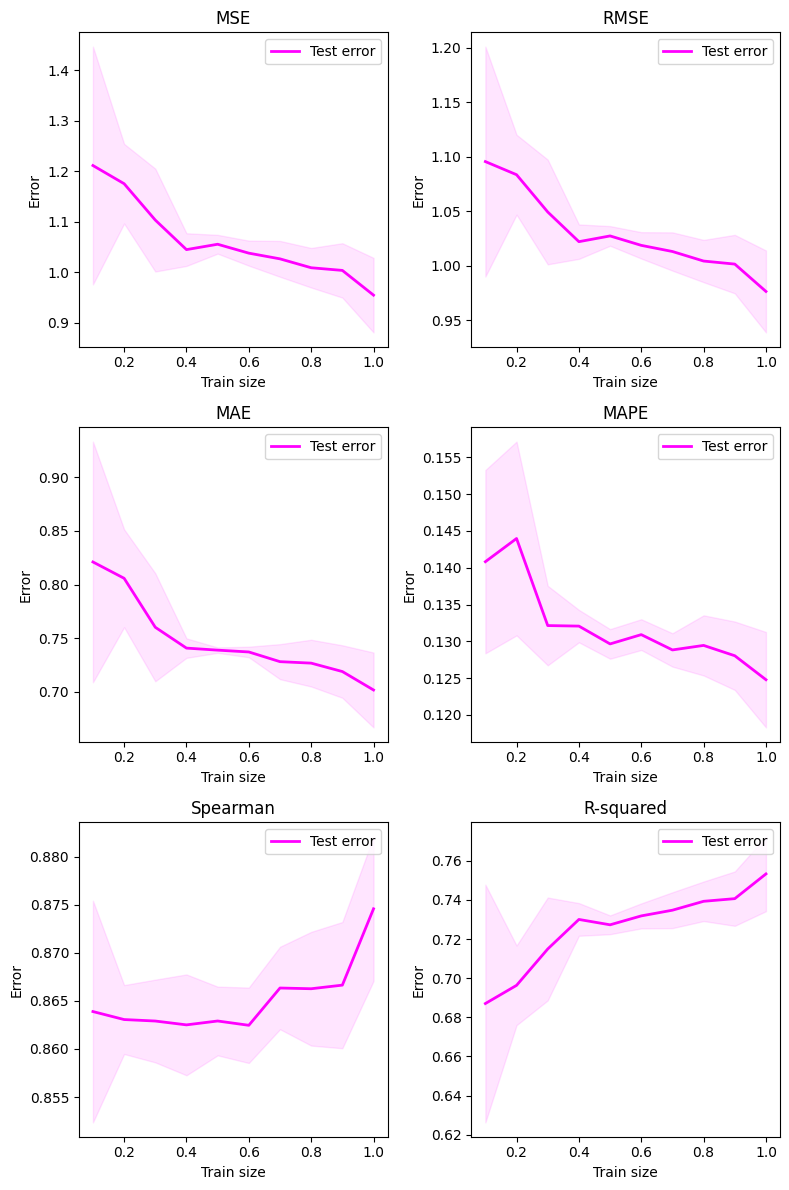

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
errors = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Spearman', 'R-squared']
for i in range(6):
    w = i%2
    h = i//2
    mean = test_err_mean[:,i]
    std = test_err_std[:,i]
    ax[h][w].set_title(errors[i],fontsize = 12)
    ax[h][w].plot(ratio, mean, linewidth=2, color='magenta', label = 'Test error')
    ax[h][w].fill_between(ratio, mean-std, mean+std, color='magenta',alpha=.1)
    ax[h][w].set_ylim(*ax[h][w].get_ylim())
    ax[h][w].set_xlabel("Train size")
    ax[h][w].set_ylabel("Error")
    ax[h][w].legend()
plt.tight_layout()
plt.show()